# Set up

In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_path = 'cats and dogs/train'
valid_path = 'cats and dogs/valid'
test_path = 'cats and dogs/test'

In [35]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dogs','cats'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dogs','cats'], batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dogs','cats'], batch_size=12)

Found 100 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [4]:
#plots images with labels in jupyter
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

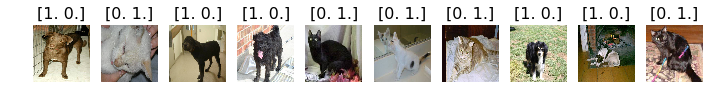

In [6]:
plots(imgs, titles=labels)

# Build and Train Naive CNN

In [7]:
model= Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax')
])

In [8]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(train_batches, steps_per_epoch=10,
                   validation_data=valid_batches, validation_steps=2, epochs=5, verbose=1)

Epoch 1/5
10/10 [==============================] - 5s 469ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
10/10 [==============================] - 3s 261ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
10/10 [==============================] - 3s 256ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
10/10 [==============================] - 3s 250ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
10/10 [==============================] - 2s 249ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


# Predict

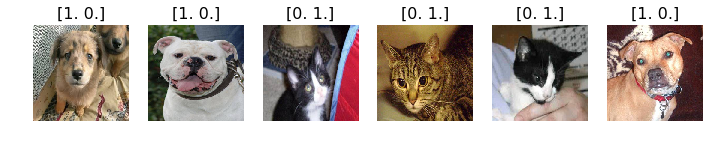

In [10]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [11]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 0., 1.], dtype=float32)

In [12]:
predictions = model.predict_generator(test_batches, steps=1, verbose=1)

2/2 [==============================] - 0s 87ms/step


In [13]:
predictions

array([[1.14724701e-34, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.84572922e-04, 9.99015450e-01],
       [0.00000000e+00, 1.00000000e+00],
       [1.02899335e-35, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [5.42115231e-21, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00]], dtype=float32)

In [15]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

In [16]:
def plot_confusion_matrix(cm, classes,
                         normalization=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    This is function prints and plots the confusion matrix.
    Normalization can be applied by setting 'True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalization:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalization confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="red" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 0]
 [3 0]]


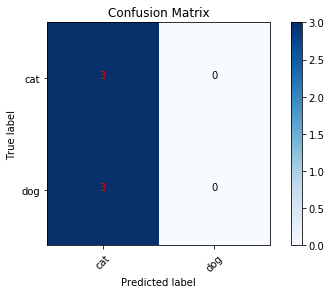

In [17]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Build Fine_tuned VGG16 Model

In [18]:
vgg16_model = keras.applications.vgg16.VGG16()

In [19]:
#vgg16_model.summary()

In [20]:
type(vgg16_model)

keras.engine.training.Model

In [21]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [22]:
#model.summary()

In [23]:
model.layers.pop()

In [24]:
for layer in model.layers:
    layer.trainable = False

In [25]:
model.add(Dense(2, activation='softmax'))

In [26]:
#model.summary()

In [27]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit_generator(train_batches, steps_per_epoch=10,
                   validation_data=valid_batches, validation_steps=2, epochs=5, verbose=1)

Epoch 1/5
10/10 [==============================] - 30s 3s/step - loss: 0.6812 - acc: 0.7800 - val_loss: 0.6772 - val_acc: 0.8000
Epoch 2/5
10/10 [==============================] - 31s 3s/step - loss: 0.6682 - acc: 0.9200 - val_loss: 0.6732 - val_acc: 0.8000
Epoch 3/5
10/10 [==============================] - 31s 3s/step - loss: 0.6605 - acc: 0.9600 - val_loss: 0.6706 - val_acc: 0.8000
Epoch 4/5
10/10 [==============================] - 31s 3s/step - loss: 0.6559 - acc: 1.0000 - val_loss: 0.6681 - val_acc: 0.8000
Epoch 5/5
10/10 [==============================] - 31s 3s/step - loss: 0.6521 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.8000


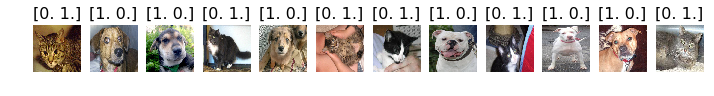

In [36]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [37]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)

In [38]:
predictions = model.predict_generator(test_batches, steps=1, verbose=1)

1/1 [==============================] - 3s 3s/step


In [39]:
predictions

array([[0.4732946 , 0.5267054 ],
       [0.5286108 , 0.4713892 ],
       [0.5165465 , 0.48345345],
       [0.47237384, 0.52762616],
       [0.520007  , 0.47999293],
       [0.47336704, 0.52663296],
       [0.47363386, 0.5263662 ],
       [0.51179284, 0.4882071 ],
       [0.47343346, 0.5265665 ],
       [0.51058453, 0.48941547],
       [0.51611525, 0.4838848 ],
       [0.47312105, 0.526879  ]], dtype=float32)

In [40]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[6 0]
 [0 6]]


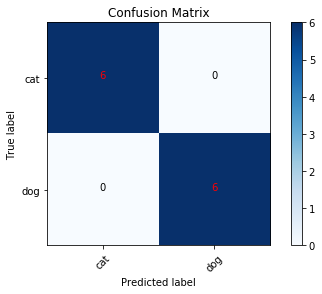

In [41]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')